<a href="https://colab.research.google.com/github/jschw/keras_timeseries_classification/blob/master/Curve_Dataset_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages
#!pip3 install onnx onnxconverter-common keras2onnx
!pip3 install onnxmltools onnxruntime

In [ ]:
# Imports

import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import onnxmltools
#import keras2onnx

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Functions

# Define neural network model
def get_model():
    model = Sequential()
    model.add(Dense(64, input_dim=20, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    Adadelta =  optimizers.Adadelta(lr = 1)
    model.compile(loss='categorical_crossentropy', optimizer=Adadelta, metrics=['accuracy'])
    
    return model

# Plotter help functions
def plotter_train(training,validation,title):
    plt.figure(figsize=(10,10))
    n = len(training)
    x = np.linspace(0,200,n)
    training = np.array(training)
    validation = np.array(validation)
    plt.plot(x, training, 'g-', label = 'Training', linewidth =2)
    plt.plot(x, validation, 'r', label = 'Validation')
    plt.grid(True)
    plt.xlabel('Number of Epoch')
    plt.ylabel(title,fontsize=12)
    plt.title(title,fontsize=24)
    plt.legend()
    plt.show()

def plotter_data(x_data, y_data, title):
    fig = plt.figure(figsize=[10,10])
    plt.plot(x_data,y_data,'--x')
    plt.xlabel('X-axis',fontsize=14)
    plt.ylabel('Y-axis',fontsize=14)
    plt.axhline(y=0, color ="k")
    plt.axvline(x=0, color ="k")
    plt.grid(True)
    plt.show()

# Load and preprocess the dataset

In [ ]:
# Load Dataset

data = pd.read_csv('curve_dataset_train.csv', index_col=False)
data= data.sample(frac=1, random_state=42).reset_index()
data.drop(['index'], 1, inplace=True)
print(data.shape)
data[:9][['shape', 'x1', 'y1','x2', 'y2','x3', 'y3','x4', 'y4','x5', 'y5','x6', 'y6','x7', 'y7','x8', 'y8','x9', 'y9','x10', 'y10']]


(3000, 21)


,shape,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10
0,circle,5.799098,2.886785,5.980137,2.097346,6.295511,1.351337,6.735637,0.671425,7.287142,0.078270,7.933268,-0.410106,8.654384,-0.778863,9.428578,-1.016798,10.232328,-1.116681,11.041211,-1.075476
1,circle,3.654798,-1.789780,2.359807,-1.998714,1.120770,-2.429347,-0.024664,-3.068594,-1.041693,-3.897032,-1.899414,-4.889489,-2.571765,-6.015810,-3.038319,-7.241773,-3.284898,-8.530126,-3.304011,-9.841725
2,circle,10.698867,11.603182,8.615402,12.448563,6.416791,12.919310,4.169838,13.001121,1.942815,12.691509,-0.196611,11.999883,-2.183435,10.947257,-3.957288,9.565614,-5.464273,7.896935,-6.658600,5.991922
3,parabola,2.860412,0.187164,1.470891,1.549967,0.089348,2.973353,-1.284218,4.457320,-2.649805,6.001869,-4.007415,7.607000,-5.357047,9.272712,-6.698701,10.999007,-8.032377,12.785883,-9.358075,14.633341
4,line,3.134748,2.879625,3.430366,4.115836,3.725983,5.352047,4.021601,6.588258,4.317218,7.824469,4.612836,9.060680,4.908453,10.296891,5.204070,11.533102,5.499688,12.769313,5.795305,14.005524
5,circle,4.132642,0.350400,3.493689,0.848124,2.778014,1.227333,2.007363,1.476505,1.205151,1.588070,0.395754,1.558638,-0.396236,1.389102,-1.146754,1.084614,-1.832996,0.654426,-2.434111,0.111609
6,circle,-23.006002,5.831956,-24.018442,2.776739,-24.484969,-0.407871,-24.391406,-3.625111,-23.740597,-6.777226,-22.552316,-9.768443,-20.862669,-12.507872,-18.722993,-14.912280,-16.198304,-16.908609,-13.365311,-18.436201
7,line,10.101848,-8.910771,6.844379,-7.986193,3.586909,-7.061615,0.329440,-6.137037,-2.928029,-5.212459,-6.185498,-4.287881,-9.442967,-3.363303,-12.700437,-2.438724,-15.957906,-1.514146,-19.215375,-0.589568
8,parabola,11.715961,10.272426,13.215705,14.144118,14.707499,18.565696,16.191344,23.537161,17.667238,29.058511,19.135183,35.129749,20.595178,41.750872,22.047223,48.921883,23.491319,56.642779,24.927464,64.913562


In [ ]:
# Preprocess

# Split x/y
X = data.values[:,0:-1]
Y = data.values[:,-1]

X = X.astype('float32')

print(X.shape)
print(' ')
print(X)
print(' ')
print(Y)
print(' ')

# Encode label vector
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y)

# Transform labels to categorical (=ne-hot-encoding)
dummy_y = to_categorical(encoded_Y)

mapping = dict(zip(encoder.classes_, range(1, len(encoder.classes_)+1)))
print('Class mapping:')
print(mapping)
print(dummy_y)


(3000, 20)
 
[[ 5.799098   2.886785   5.9801373 ... -1.1166809 11.041211  -1.0754764]
 [ 3.6547983 -1.7897797  2.3598068 ... -8.530127  -3.304011  -9.841725 ]
 [10.698867  11.603182   8.615402  ...  7.896935  -6.6586     5.991922 ]
 ...
 [ 9.374282  -7.1663156  9.639446  ... -7.6468654 12.405381  -7.431783 ]
 [ 3.1423914  8.584241   1.1868674 ... -1.5941349 -7.3658776 -3.5747368]
 [ 3.2282054 -3.817263   3.0947351 ... -9.712591  23.490572  -9.052892 ]]
 
['circle' 'circle' 'circle' ... 'circle' 'circle' 'parabola']
 
Class mapping:
{'circle': 1, 'line': 2, 'parabola': 3}
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


# Define the model and train it

In [ ]:
# Build model
model = get_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                5

In [ ]:
# Train model
history = model.fit(x=X,y=dummy_y,validation_split=0.2,shuffle=True, epochs=40, batch_size=10)

train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

Epoch 1/40
240/240 [==============================] - 1s 5ms/step - loss: 4.3759 - accuracy: 0.3688 - val_loss: 1.0383 - val_accuracy: 0.3533
Epoch 2/40
240/240 [==============================] - 1s 4ms/step - loss: 1.5173 - accuracy: 0.3338 - val_loss: 1.0538 - val_accuracy: 0.3333
Epoch 3/40
240/240 [==============================] - 1s 4ms/step - loss: 1.2725 - accuracy: 0.3571 - val_loss: 1.0521 - val_accuracy: 0.3950
Epoch 4/40
240/240 [==============================] - 1s 4ms/step - loss: 1.1339 - accuracy: 0.3796 - val_loss: 0.9990 - val_accuracy: 0.4100
Epoch 5/40
240/240 [==============================] - 1s 4ms/step - loss: 1.1028 - accuracy: 0.4046 - val_loss: 0.9458 - val_accuracy: 0.6250
Epoch 6/40
240/240 [==============================] - 1s 4ms/step - loss: 1.0617 - accuracy: 0.4392 - val_loss: 0.8825 - val_accuracy: 0.6933
Epoch 7/40
240/240 [==============================] - 1s 4ms/step - loss: 0.9937 - accuracy: 0.4737 - val_loss: 0.7999 - val_accuracy: 0.7183
Epoch 

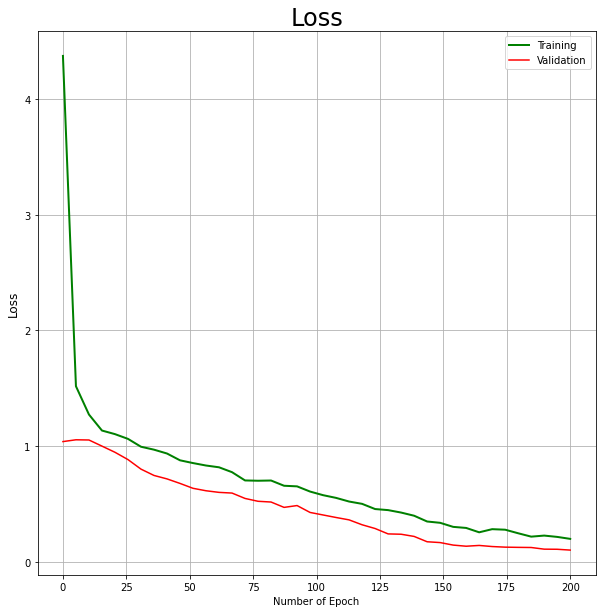

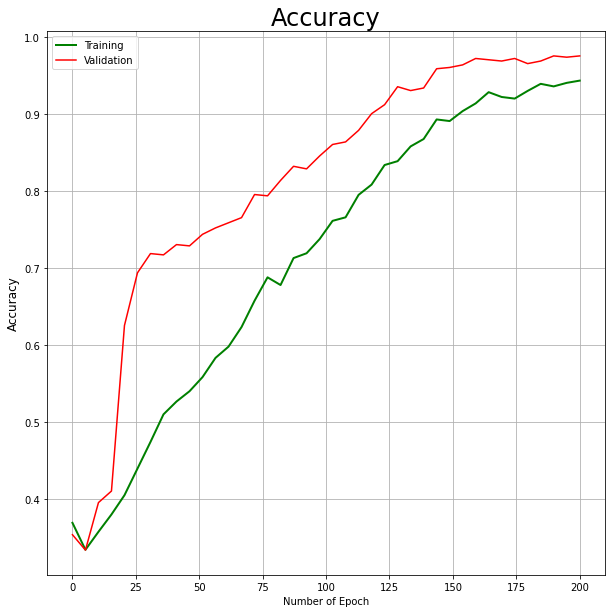

In [ ]:
# Visualize training history

plotter_train(train_loss,val_loss,'Loss')
plotter_train(train_acc,val_acc,'Accuracy')

In [ ]:
# Evaluate trained model with k-fold corssvalidation method

seed = 7
np.random.seed(seed)

estimator = KerasClassifier(build_fn=get_model, epochs=40, batch_size=10, verbose=0)

kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

results = cross_val_score(estimator, X, dummy_y, cv=kfold)
print("K-Fold Crossvalidation Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

K-Fold Crossvalidation Accuracy: 99.97% (0.10%)


# Test the model with the test dataset

Class mapping:
{'circle': 1, 'line': 2, 'parabola': 3}
 


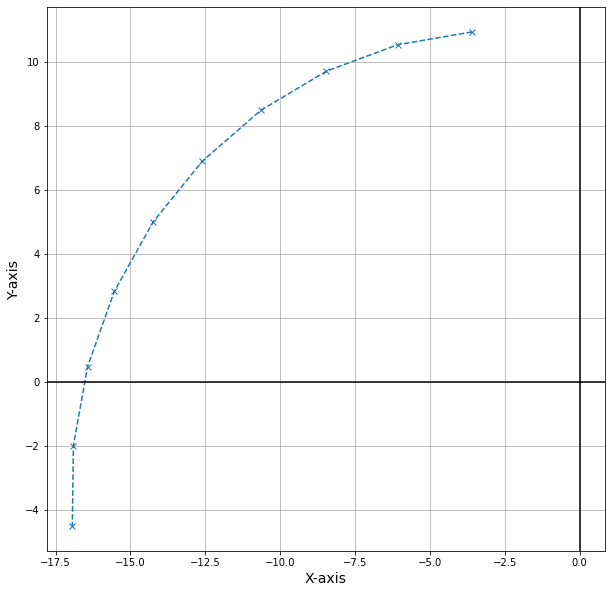

Predicted class no.: 0
Ground truth.: 0
Prediction confidence: 99.65 %
Processing time for prediction: 0.035 ms


In [ ]:
# Make a test predicition

# Load test dataset
data_test = pd.read_csv('curve_dataset_test.csv', index_col=False)
data_test = data_test.sample(frac=1, random_state=42).reset_index()
data_test.drop(['index'], 1, inplace=True)

data_test[:9][['shape', 'x1', 'y1','x2', 'y2','x3', 'y3','x4', 'y4','x5', 'y5','x6', 'y6','x7', 'y7','x8', 'y8','x9', 'y9','x10', 'y10']]

# Split x/y
X_test = data_test.values[:,0:-1]
Y_test = data_test.values[:,-1]

X_test = X_test.astype('float32')




# Encode label vector
encoder = LabelEncoder()
encoded_Y_test = encoder.fit_transform(Y_test)

# Transform labels to categorical (=one-hot-encoding)
dummy_y_test = to_categorical(encoded_Y_test)
mapping = dict(zip(encoder.classes_, range(1, len(encoder.classes_)+1)))
print('Class mapping:')
print(mapping)


# Specific sample
#predict_arr = X_test[15].reshape(1,20)
#predict_ground_truth = dummy_y_test[15]

# Random sample
rand_index = np.random.choice(len(X_test), 1)
predict_arr = X_test[rand_index].reshape(1,20)
predict_ground_truth = dummy_y_test[rand_index]



#print(X_test.shape)
#print(predict_arr)
#print(predict_arr.shape)
print(' ')


x_data = predict_arr[0,0::2]
y_data = predict_arr[0,1::2]


plotter_data(x_data, y_data, 'Data for test prediction')

start_preprocessing = time.time()
prediction = model.predict(predict_arr)
end_preprocessing = time.time()

pred_conf = prediction[0, np.argmax(prediction)]
pred_conf = round(pred_conf*100, 2)

pred_time = round((end_preprocessing-start_preprocessing), 3)

#print(prediction)
print('Predicted class no.: ' + str(np.argmax(prediction)))
print('Ground truth.: ' + str(np.argmax(predict_ground_truth)))
print('Prediction confidence: ' + str(pred_conf) + ' %')
print('Processing time for prediction: ' + str(pred_time) + ' ms')

# Convert and save it

In [ ]:
# Save and convert model to ONNX
model.save('model_curvetypes.h5')

onnx_model = onnxmltools.convert_keras(model, model.name)
onnxmltools.utils.save_model(onnx_model, 'model_curvetypes.onnx')

tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 23 -> 15
The maximum opset needed by this model is only 9.


The model expects input shape:  ['N', 20]
The shape of the data array is:  (1, 20)
 
Input name: dense_input
Input label name: dense_4
 
The output shape is: (1, 1, 3)
 


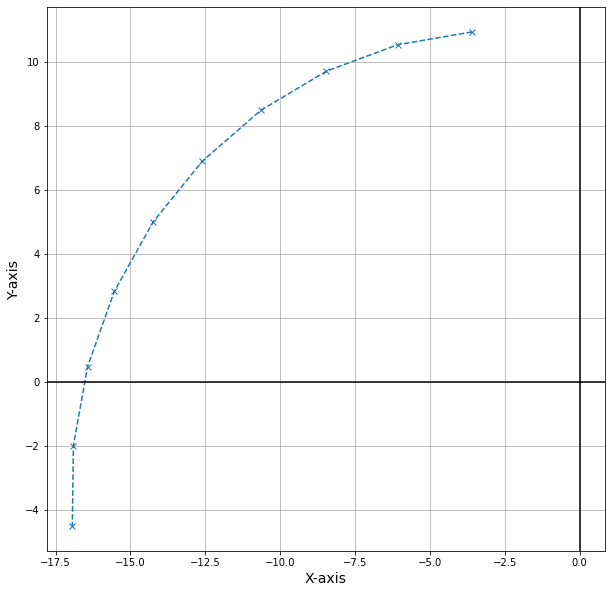

Predicted class no.: 0
Ground truth.: 0
Prediction confidence: 99.65 %
Processing time for prediction: 0.017 ms


In [ ]:
# Test ONNX 

#!pip3 install onnxruntime
import onnxruntime as onnxrun

sess = onnxrun.InferenceSession("model_curvetypes.onnx")

print("The model expects input shape: ", sess.get_inputs()[0].shape)
print("The shape of the data array is: ", predict_arr.shape)
print(' ')

input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name

print('Input name: ' + input_name)
print('Input label name: ' + label_name)
print(' ')

start_preprocessing = time.time()
prediction = np.array(sess.run(None, {input_name: predict_arr}))
end_preprocessing = time.time()

print('The output shape is: ' + str(prediction.shape))
print(' ')

plotter_data(x_data, y_data, 'Data for test prediction')

pred_conf = prediction[0, 0, np.argmax(prediction)]
pred_conf = round(pred_conf*100, 2)

pred_time = round((end_preprocessing-start_preprocessing), 3)


#print(prediction)
print('Predicted class no.: ' + str(np.argmax(prediction)))
print('Ground truth.: ' + str(np.argmax(predict_ground_truth)))
print('Prediction confidence: ' + str(pred_conf) + ' %')
print('Processing time for prediction: ' + str(pred_time) + ' ms')